# Predicting Salary

Data source: Data Science Salary

## 1. Prepare environment

In [1]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

from environment import prepare_environment
from torch.utils.data import TensorDataset, DataLoader, random_split

In [2]:
# Global variables
SEED = 42

In [3]:
# Check if your GPU driver and CUDA is enabled and accessible by PyTorch
torch.cuda.is_available()

True

In [4]:
# Environment configuration
torch.set_printoptions(precision=10)
np.random.seed(SEED)

prepare_environment()

## 2. Read dataset

In [5]:
df = pd.read_csv('data-sources/data-salaries.csv')
df = df[['experience_level', 'employment_type', 'remote_ratio',
         'company_size', 'salary_in_usd']]

# Encoding categorical variables
df['experience_level'] = df.experience_level.astype('category').cat.codes
df['employment_type'] = df.employment_type.astype('category').cat.codes
df['company_size'] = df.company_size.astype('category').cat.codes

# Normalizing numerical variables
min_sal = df.salary_in_usd.min()
max_sal = df.salary_in_usd.max()
df['remote_ratio'] = (df.remote_ratio-df.remote_ratio.min())/(df.remote_ratio.max()-df.remote_ratio.min())
df['salary_in_usd'] = (df.salary_in_usd-min_sal)/(max_sal-min_sal)

df.head()

,experience_level,employment_type,remote_ratio,company_size,salary_in_usd
0,0,2,0.5,0,0.102982
1,3,2,1.0,0,0.109780
2,1,2,0.0,1,0.137533
3,1,2,0.5,0,0.380363
4,0,2,1.0,2,0.204520


## 3. Split into train, valid and test

In [6]:
# Setting X and y
features = df.drop(columns='salary_in_usd').values
labels = df[['salary_in_usd']].values

# Instantiate dataset class
dataset = TensorDataset(torch.tensor(features).float(),
                        torch.tensor(labels).float())

# Splitting into training, validation and testing set
set_train, set_val = random_split(dataset, [.8, .2])
set_val, set_test = random_split(set_val, [.5, .5])

len(set_train), len(set_val), len(set_test)

(196, 25, 24)

In [7]:
# Creating dataloaders
loader_train = DataLoader(set_train, batch_size=200, shuffle=True)
loader_val = DataLoader(set_val, batch_size=200, shuffle=True)
loader_test = DataLoader(set_test, batch_size=200, shuffle=True)

len(loader_train), len(loader_val), len(loader_test)  # Just one batch created

(1, 1, 1)

## 4. Build the model

In [8]:
# Create linear regression model
model = nn.Sequential(
    nn.Linear(4, 6),
    nn.Linear(6, 3),
    nn.Linear(3, 1),
    nn.Sigmoid() # Regression problem
)

criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

## 5. Train on the training set

In [9]:
# Set the model to training mode
model.train()

# Loop through the dataset multiple times
losses = []
epochs = int(1e3)
for epoch in range(epochs):
    for data in loader_train:
        X, y = data                    # Get feature and target from the data loader
        optimizer.zero_grad()          # zero the parameter gradients
        y_pred = model(X)              # Run a forward pass
        loss = criterion(y_pred, y)    # Compute loss 
        loss.backward()                # Backward pass
        optimizer.step()               # Optimization
    
    losses.append(loss.item())         # Record the loss per epoch
    if (epoch + 1) % 100 == 0:         # Print the loss every 100 epochs
        print(f'Epoch [{epoch+1}], Loss: {loss.item():.4f}')

training_loss = loss

Epoch [100], Loss: 0.0440
Epoch [200], Loss: 0.0295
Epoch [300], Loss: 0.0253
Epoch [400], Loss: 0.0238
Epoch [500], Loss: 0.0231
Epoch [600], Loss: 0.0227
Epoch [700], Loss: 0.0224
Epoch [800], Loss: 0.0222
Epoch [900], Loss: 0.0220
Epoch [1000], Loss: 0.0218


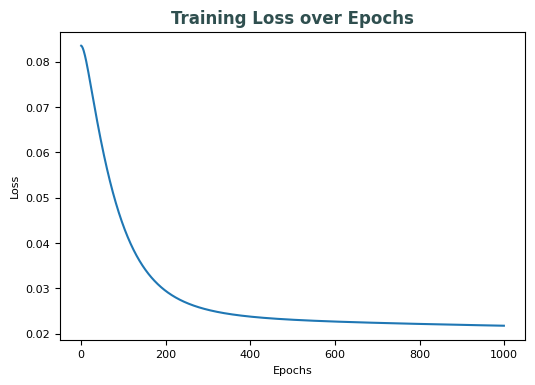

In [10]:
# Visualizing the loss data in training set
fig = plt.figure(figsize=(6,4))
plt.plot(range(epochs), losses)
plt.title("Training Loss over Epochs")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

## 6. Evaluate model

In [11]:
# Set the model to evaluation mode
model.eval()

# Iterating over validation dataloader
with torch.no_grad():
    for data in loader_val:
        X, y = data                   # Get feature and target from the data loader
        y_pred = model(X)             # Get predictions
        loss = criterion(y_pred, y)   # Calculate the loss
      
# Comparing loss value
print(f'Training   Set: Loss >> {training_loss}')
print(f'Validation Set: Loss >> {loss}')

Training   Set: Loss >> 0.021784542128443718
Validation Set: Loss >> 0.014137735590338707


In [12]:
pd.DataFrame({
    'y_true': y.numpy().flatten(),
    'y_pred': y_pred.numpy().flatten(),
    'Diff'  : y.numpy().flatten() - y_pred.numpy().flatten(),
    'Expected Salary': y.numpy().flatten() * (max_sal - min_sal) + min_sal,
    'Predicted Salary': y_pred.numpy().flatten() * (max_sal - min_sal) + min_sal
})

,y_true,y_pred,Diff,Expected Salary,Predicted Salary
0,0.144905,0.155309,-0.010404,89401.995735,95614.548386
1,0.204520,0.187669,0.016852,124999.997431,114937.366786
2,0.310026,0.106760,0.203266,187999.994850,66624.853062
3,0.142491,0.104876,0.037615,87960.999287,65500.268288
4,0.162653,0.261821,-0.099168,100000.000574,159215.781817
5,0.094997,0.190722,-0.095725,59600.999720,116760.596687
6,0.001882,0.259902,-0.258020,4000.000019,158069.935651
7,0.196147,0.152455,0.043691,119999.998060,93910.816489
8,0.021922,0.146482,-0.124560,15965.999805,90343.672041
9,0.271508,0.106760,0.164748,165000.001300,66624.853062


----------------------------------